In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm

from CRDDM.Models import PSDM

import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution as DE

# Simulation:

In [2]:
threshold = 2
drift_vector = np.array([2, 1])
ndt = 0.3

df = PSDM.rng(threshold, drift_vector, ndt, n_sample=1000)

In [3]:
df

,rt,response
0,1.212,0.092921
1,0.686,1.037617
2,1.234,1.362111
3,0.983,1.726742
4,1.027,0.530610
...,...,...
995,0.661,0.058084
996,0.635,1.025493
997,0.677,0.795134
998,0.610,0.285632


In [4]:
# plt.figure(figsize=(9, 4), layout='constrained')
# plt.subplot(121)
# t = np.linspace(0.01, df['rt'].max(), 200)
# plt.plot(t+ndt, PSDM.response_time_pdf(t, threshold, drift_vector), color='red')
# sns.histplot(df['rt'], stat='density');

# plt.subplot(122)
# theta = np.linspace(-3.14, 3.14, 200)
# plt.plot(theta, PSDM.response_pdf(theta, threshold, drift_vector), color='red')
# sns.histplot(df['response'], stat='density');

# Parameter recovery:

In [5]:
def fit_psdm(prms, rt, theta):
    threshold =  prms[0] # decision threshold
    ndt = prms[1] # non-decision time
    drift_vec = np.array([prms[2], prms[3]]) # drift vector
    
    return -np.sum(PSDM.joint_lpdf(rt, theta, threshold, drift_vec, ndt))

In [6]:
n_trials = 300
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu_x_true': [],
               'mu_x_estimate': [],
               'mu_y_true': [],
               'mu_y_estimate': []}

# These are the bounds for parameter estimation
min_threshold = 0.05
max_threshold = 5

min_ndt = 0
max_ndt = 2

min_mu = -5
max_mu = 5

prms_bounds = [(min_threshold, max_threshold), (min_ndt, max_ndt),
               (min_mu, max_mu), (0, max_mu)]

In [7]:
for n in tqdm(range(100)):
    # generating some random parameters
    threshold = np.random.uniform(0.5, max_threshold)
    mu_x = np.random.uniform(min_mu, max_mu)
    mu_y = np.random.uniform(0, max_mu)
    drift_vector = np.array([mu_x, mu_y])
    ndt = np.random.uniform(0.05, max_ndt)
    
    sim_df = PSDM.rng(threshold, drift_vector, ndt, n_sample=n_trials)
    
    # Estimating the paramters for the simulated data
    min_ans = DE(fit_psdm, args=(sim_df['rt'].values, sim_df['response'].values), bounds=prms_bounds)

    
    # Storing the true generating parameters
    recovery_df['threshold_true'].append(threshold)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu_x_true'].append(mu_x)
    recovery_df['mu_y_true'].append(mu_y)
    
    # Stroing the estimated parameters
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['ndt_estimate'].append(min_ans.x[1])
    recovery_df['mu_x_estimate'].append(min_ans.x[2])
    recovery_df['mu_y_estimate'].append(min_ans.x[3])

100%|█████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


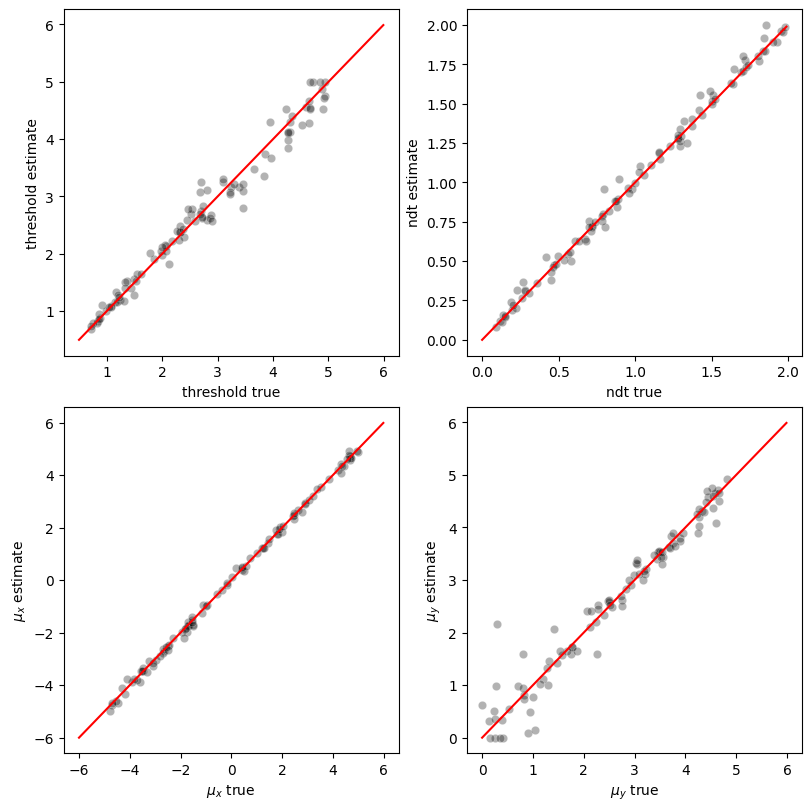

In [8]:
plt.figure(figsize=(8, 8), layout='constrained')

plt.subplot(221)
plt.plot(np.arange(.5, 6, 0.01), np.arange(.5, 6, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'threshold true')
plt.ylabel(r'threshold estimate')

plt.subplot(222)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate')

plt.subplot(223)
plt.plot(np.arange(-6, 6, 0.01), np.arange(-6, 6, 0.01), c='red')
sns.scatterplot(x='mu_x_true', y='mu_x_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_x$ true')
plt.ylabel(r'$\mu_x$ estimate');

plt.subplot(224)
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red')
sns.scatterplot(x='mu_y_true', y='mu_y_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_y$ true')
plt.ylabel(r'$\mu_y$ estimate');
